In [1]:
import tsflex
print(tsflex.__version__)

0.1.1.9


## Get the data

In [2]:
import pandas as pd

url = "https://github.com/predict-idlab/tsflex/raw/main/examples/data/empatica/"
df_tmp = pd.read_parquet(url+"tmp.parquet").set_index("timestamp")
df_acc = pd.read_parquet(url+"acc.parquet").set_index("timestamp")
df_gsr = pd.read_parquet(url+"gsr.parquet").set_index("timestamp")
df_ibi = pd.read_parquet(url+"ibi.parquet").set_index("timestamp")

data = [df_tmp, df_acc, df_gsr, df_ibi]

In [3]:
from pandas.tseries.frequencies import to_offset

for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data]
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

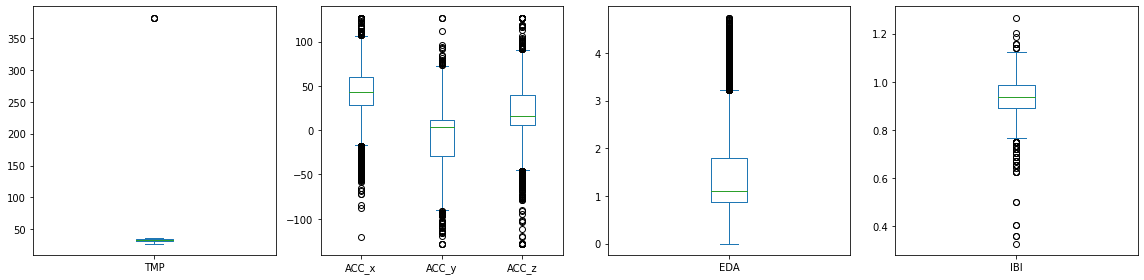

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

In [6]:
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Import / create the processing functions
import numpy as np
from scipy.signal import savgol_filter

def clip_quantiles(sig: pd.Series, lower_q=0.01, upper_q=0.99) -> np.ndarray:
    # Note that this function induces a data leakage
    quantile_vals = np.quantile(sig, q=[lower_q, upper_q])
    return np.clip(sig, *quantile_vals)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
clipper_tmp = SeriesProcessor(clip_quantiles, series_names="TMP", lower_q=0, upper_q=0.999)
savgol_eda = SeriesProcessor(savgol_filter, "EDA", window_length=5, polyorder=2)
savgol_acc = SeriesProcessor(savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2)
smv_processor = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))
clipper_smv = SeriesProcessor(clip_quantiles, "ACC_SMV")

# Create the series pipeline
series_pipe = SeriesPipeline(
    processors=[clipper_tmp, savgol_eda, savgol_acc, smv_processor, clipper_smv]
)
series_pipe

[
	clip_quantiles {'lower_q': 0, 'upper_q': 0.999} :  ('TMP',)
	savgol_filter {'window_length': 5, 'polyorder': 2} :  ('EDA',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
	clip_quantiles {} :  ('ACC_SMV',)
]

In [7]:
# Process the data
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

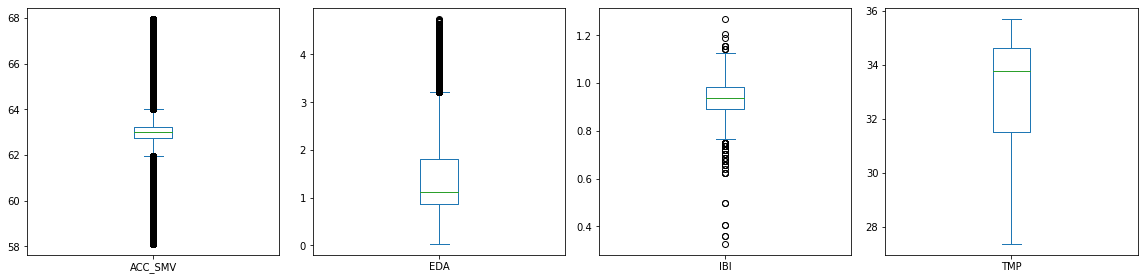

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction

In [9]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

# Import / create the feature functions
from scipy.stats import skew

def area(sig: np.ndarray) -> float:
    return np.sum(np.abs(sig))

# Create the feature descriptors
general_feats = MultipleFeatureDescriptors(
        functions=[np.min, np.max, np.mean, np.std],
        series_names=["ACC_SMV", "EDA", "TMP", "IBI"],
        windows=["5min", "2.5min"],
        strides="2min",
)
eda_feats = MultipleFeatureDescriptors(
        functions=[skew, area],
        series_names="EDA",
        windows=["7.5min", "5min", "2.5min"],
        strides="2min",
)

# Create the feature collection
feature_collection = FeatureCollection(
    feature_descriptors=[general_feats, eda_feats]
)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: NumpyFuncWrapper(amin, ['amin'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(amax, ['amax'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(std, ['std'], {}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescriptor - func: NumpyFuncWrapper(amin, ['amin'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(amax, ['amax'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(std, ['std'], {}),
	]
)
EDA: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: NumpyFuncWrapper(amin, ['amin'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(amax, ['amax'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(mean, ['mean'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(std, ['std'], {}),
		FeatureDescriptor - func: NumpyFuncWrapper(skew, ['skew'], {}),
		FeatureDescriptor - func: NumpyFuncW

In [10]:
# Calculate the features
features_df = feature_collection.calculate(out_data, return_df=True, approve_sparsity=True, error_val=np.nan)
features_df

,ACC_SMV__amin__w=5m_s=2m,ACC_SMV__amax__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__amax__w=5m_s=2m,ACC_SMV__amin__w=2m30s_s=2m,EDA__amin__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,EDA__amax__w=5m_s=2m,EDA__amin__w=2m30s_s=2m,EDA__mean__w=5m_s=2m,...,IBI__amax__w=5m_s=2m,TMP__std__w=5m_s=2m,IBI__mean__w=5m_s=2m,IBI__mean__w=2m30s_s=2m,EDA__area__w=7m30s_s=2m,TMP__std__w=2m30s_s=2m,IBI__std__w=5m_s=2m,IBI__std__w=2m30s_s=2m,EDA__skew__w=2m30s_s=2m,EDA__skew__w=7m30s_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,63.023753,NaN,0.034604,NaN,...,NaN,NaN,NaN,NaN,NaN,0.752281,NaN,NaN,0.268009,NaN
2017-06-13 14:24:55.625578+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.867227,NaN,NaN,NaN,0.058726,NaN,NaN
2017-06-13 14:26:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,62.947692,NaN,0.064495,NaN,...,NaN,NaN,NaN,NaN,NaN,0.379786,NaN,NaN,-0.003527,NaN
2017-06-13 14:26:55.625578+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-13 14:27:13+02:00,58.115565,NaN,63.029935,67.93911,NaN,0.034604,NaN,1.021668,NaN,0.642810,...,NaN,0.911342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:25:13+02:00,58.115565,NaN,63.062381,67.93911,NaN,0.623766,NaN,1.064344,NaN,0.836712,...,NaN,0.205881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-13 16:25:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1556.734619,NaN,NaN,NaN,NaN,-0.677817
2017-06-13 16:26:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,63.041643,NaN,0.744315,NaN,...,NaN,NaN,NaN,NaN,NaN,0.068478,NaN,NaN,-0.843564,NaN


In [11]:
ibi_features = features_df[[c for c in features_df.columns if 'IBI_' in c]]
ibi_features = ibi_features[ibi_features.isna().sum(axis=1) < len(ibi_features.columns)]
ibi_features

,IBI__amax__w=2m30s_s=2m,IBI__amin__w=2m30s_s=2m,IBI__amin__w=5m_s=2m,IBI__amax__w=5m_s=2m,IBI__mean__w=5m_s=2m,IBI__mean__w=2m30s_s=2m,IBI__std__w=5m_s=2m,IBI__std__w=2m30s_s=2m
timestamp,,,,,,,,
2017-06-13 14:24:55.625578+02:00,0.984420,0.750034,NaN,NaN,NaN,0.867227,NaN,0.058726
2017-06-13 14:27:25.625578+02:00,NaN,NaN,0.750034,1.031297,0.872199,NaN,0.064306,NaN
2017-06-13 14:28:55.625578+02:00,1.031297,0.500023,NaN,NaN,NaN,0.753159,NaN,0.227600
2017-06-13 14:29:25.625578+02:00,NaN,NaN,0.406269,1.031297,0.695344,NaN,0.244706,NaN
2017-06-13 14:30:55.625578+02:00,0.750034,0.406269,NaN,NaN,NaN,0.578151,NaN,0.171882
...,...,...,...,...,...,...,...,...
2017-06-13 16:15:25.625578+02:00,NaN,NaN,0.656280,1.031297,0.908896,NaN,0.090628,NaN
2017-06-13 16:16:55.625578+02:00,1.046923,0.875040,NaN,NaN,NaN,0.964330,NaN,0.054587
2017-06-13 16:17:25.625578+02:00,NaN,NaN,0.703157,1.046923,0.934538,NaN,0.087326,NaN


In [12]:
other_features = features_df[[c for c in features_df.columns if not 'IBI_' in c]]
other_features = other_features[other_features.isna().sum(axis=1) < len(other_features.columns)]
other_features

,ACC_SMV__amin__w=5m_s=2m,ACC_SMV__amax__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__amax__w=5m_s=2m,ACC_SMV__amin__w=2m30s_s=2m,EDA__amin__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,EDA__amax__w=5m_s=2m,EDA__amin__w=2m30s_s=2m,EDA__mean__w=5m_s=2m,...,TMP__amax__w=2m30s_s=2m,TMP__amin__w=2m30s_s=2m,TMP__amax__w=5m_s=2m,TMP__mean__w=2m30s_s=2m,EDA__skew__w=5m_s=2m,TMP__std__w=5m_s=2m,EDA__area__w=7m30s_s=2m,TMP__std__w=2m30s_s=2m,EDA__skew__w=2m30s_s=2m,EDA__skew__w=7m30s_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,63.023753,NaN,0.034604,NaN,...,35.680000,27.370001,NaN,27.835133,NaN,NaN,NaN,0.752281,0.268009,NaN
2017-06-13 14:26:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,62.947692,NaN,0.064495,NaN,...,29.510000,28.230000,NaN,29.004133,NaN,NaN,NaN,0.379786,-0.003527,NaN
2017-06-13 14:27:13+02:00,58.115565,NaN,63.029935,67.93911,NaN,0.034604,NaN,1.021668,NaN,0.642810,...,NaN,NaN,35.680000,NaN,0.506346,0.911342,NaN,NaN,NaN,NaN
2017-06-13 14:28:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,62.910095,NaN,0.474097,NaN,...,30.370001,29.430000,NaN,29.961464,NaN,NaN,NaN,0.361422,-3.434356,NaN
2017-06-13 14:29:13+02:00,58.115565,NaN,62.943671,67.93911,NaN,0.064495,NaN,1.021668,NaN,0.762167,...,NaN,NaN,30.370001,NaN,-0.788637,0.643985,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:25:13+02:00,58.115565,NaN,63.062381,67.93911,NaN,0.623766,NaN,1.064344,NaN,0.836712,...,NaN,NaN,31.090000,NaN,-0.205152,0.205881,NaN,NaN,NaN,NaN
2017-06-13 16:25:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1556.734619,NaN,NaN,-0.677817
2017-06-13 16:26:43+02:00,NaN,67.93911,NaN,NaN,58.115565,NaN,63.041643,NaN,0.744315,NaN,...,31.129999,30.889999,NaN,31.031199,NaN,NaN,NaN,0.068478,-0.843564,NaN


### Plot the IBI features

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For visualization purposes use window_idx = midle (this aligns the features better with the raw data)
features_df = feature_collection.calculate(
    out_data,
    return_df=True,
    approve_sparsity=True,
    error_val=np.nan,
    window_idx="middle",
)

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, subplot_titles=["Raw IBI data", "IBI features"]
)

fig.add_trace(
    go.Scattergl(x=df_ibi.index, y=df_ibi["IBI"].values, name="IBI", mode="markers"),
    row=1,
    col=1,
)

ibi_feats = [c for c in features_df.columns if "IBI_" in c and "w=2m30s_" in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(height=2 * 350)

fig.show(renderer="iframe")